<a href="https://colab.research.google.com/github/MuraliB123/Job_Recom/blob/main/Dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#1. Load the dataset
import json
import pandas as pd
with open('/content/drive/MyDrive/Job_recom_system/assignment_test_job.json', 'r') as file:
    data = json.load(file)


2. Transform "job_functions_collections" columns to extract only functional roles.
3. Transform "job_industries_collections" columns to extract only industries associated with each job.
4. Delete job_status_log_collection and few other columns as shown below.


In [2]:
def extract_and_assign(data):
    for job in data:
      functional_roles = []
      for item in job["job_functions_collection"]:
        function = item["job_function_list"]["function"]
        functional_roles.append(function)
      if len(functional_roles) > 0:
        job["job_functions_collection"] = functional_roles[0]
      else:
        job["job_functions_collection"] = "N/A"

    for job in data:
      industries = []
      for item in job["job_industries_collection"]:
        industry = item["job_industry_list"]["industry"]
        industries.append(industry)
      job["job_industries_collection"] = industries

    for job in data:
      del job['job_status_log_collection']
      del job['_id']
      del job['linkedin_job_id']
      del job['last_updated_ux']
      del job['redirected_url_hash']
      del job['hash']
      del job['application_active']
      del job['external_url']
      del job['redirected_url']


In [3]:
extract_and_assign(data)

5. Job_functions_collections have roles separated by ',' and 'and'. Tokensize them using split function

In [4]:
for item in data:
    item['job_functions_collection'] = [job_function.replace('and ', '').strip() for job_function in item['job_functions_collection'].split(',')]


6. Create a hash_map frequency_role which stores the frequency of each distinct functional_role.

In [5]:
from collections import Counter
functional_roles = []
for item in data:
  for role in item['job_functions_collection']:
      functional_roles.append(role)

In [6]:
word_counts = Counter(functional_roles)
frequency_role = {}
for word, count in word_counts.items():
    frequency_role[word] = count

In [7]:
frequency_role.keys() # different functional roles exists in the dataset.

dict_keys(['Engineering Information Technology', 'Business Development Sales', 'Management Manufacturing', 'Sales Business Development', 'Accounting/Auditing Finance', 'Information Technology', 'Design', 'Art/Creative', 'Marketing Sales', 'N/A', 'Other', 'Engineering', 'Legal', 'Purchasing Supply Chain', 'Finance Sales', 'Human Resources', 'Sales', 'Research', 'Analyst', 'Consulting', 'Education Training', 'Administrative', 'Project Management Information Technology', 'Information Technology Engineering', 'Project Management', 'Business Development', 'Strategy/Planning Consulting', 'Marketing', 'Public Relations', 'Writing/Editing', 'Finance', 'Health Care Provider', 'Sales Management', 'Production', 'General Business', 'Quality Assurance', 'Administrative Customer Service', 'Accounting/Auditing', 'Administrative Writing/Editing', 'Project Management Management', 'Administrative Engineering', 'Customer Service', 'Education', 'Business Development Finance', 'Strategy/Planning Informatio

6. Before doing label encoding we introduce some ordinalitty in the dataset by grouping jobs of similar functional roles together.

In [8]:
# Function to get the maximum frequency of job roles in a job's role collection
def get_max_frequency(job_functions):
    temp = max(frequency_role.get(role, 0) for role in job_functions)
    return temp

# Sort data by the maximum frequency of job roles in each job's role collection
data = sorted(data, key=lambda x: get_max_frequency(x['job_functions_collection']), reverse=True)



7. label encoding for job_functions_collection columns.

In [9]:
all_job_functions = set()
for job in data:
    all_job_functions.update(job['job_functions_collection'])


def get_frequency(job_function):
    return frequency_role.get(job_function, 0)

sorted_job_functions = sorted(all_job_functions, key=get_frequency, reverse=True)

# Create a mapping from job function to integer label
job_function_to_label = {job_function: idx for idx, job_function in enumerate(sorted_job_functions)}


# Encode job functions in the sorted data
for job in data:
    job['job_functions_collection'] = [job_function_to_label[job_function] for job_function in job['job_functions_collection']]



In [10]:
job_function_to_label # Hash map with encoded mappings

{'Information Technology': 0,
 'Engineering Information Technology': 1,
 'Sales Business Development': 2,
 'N/A': 3,
 'Other': 4,
 'Business Development Sales': 5,
 'Management Manufacturing': 6,
 'Design': 7,
 'Marketing Sales': 8,
 'Human Resources': 9,
 'Engineering': 10,
 'Art/Creative': 11,
 'Marketing': 12,
 'Writing/Editing': 13,
 'Public Relations': 14,
 'Sales': 15,
 'Administrative': 16,
 'Accounting/Auditing Finance': 17,
 'Business Development': 18,
 'Finance Sales': 19,
 'Analyst': 20,
 'Research': 21,
 'Information Technology Engineering': 22,
 'Education Training': 23,
 'Consulting': 24,
 'Quality Assurance': 25,
 'Health Care Provider': 26,
 'Management': 27,
 'Project Management Information Technology': 28,
 'Finance': 29,
 'Project Management': 30,
 'Accounting/Auditing': 31,
 'Customer Service': 32,
 'Product Management Marketing': 33,
 'Strategy/Planning': 34,
 'Production': 35,
 'General Business': 36,
 'Legal': 37,
 'Purchasing Supply Chain': 38,
 'Education': 39,

8. label encoding for seniority level column.
9. label encoding for employment type column.

In [11]:
seniority_level_mapping = {
    "Internship": 1,
    "Entry level": 2,
    "Mid-Senior level": 3,
    "Associate": 4,
    "Executive":5,
    "Director": 6,
    "Not Applicable": 7,
    '': 8

}

In [12]:
for job in data:
  job["seniority"] = seniority_level_mapping[job["seniority"]]

In [13]:
employment_types_mapping = {
    'Internship' : 1,
    'Part-time' : 2,
    'Contract'  : 3,
    'Full-time' : 4,
    'Temporary' : 5,
    'Other' : 6
}

In [14]:
for job in data:
  job["employment_type"] = employment_types_mapping[job["employment_type"]]

10. For initial recomendations we takes three features. seniority_level, employment_type, functional roles of interest.
11. KNN Algorithm is built on the dataset.

In [15]:
import json
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
# Prepare the features
max_length = max(len(job["job_functions_collection"]) for job in data)
def encode_job(job):
    seniority = job["seniority"]
    employment_type = job["employment_type"]
    job_functions = job["job_functions_collection"]

    # Pad job functions to max_length
    job_functions_padded = job_functions + [-1] * (max_length - len(job_functions))

    return [seniority, employment_type] + job_functions_padded
features = []
for job in data:
    features.append(encode_job(job))
X = np.array(features)


12. Below cell is for testing the inference

In [16]:
seniority_input = "Mid-Senior level"
employment_type_input = "Full-time"
job_functions_input = ["Information Technology"]

In [17]:
input_features = [seniority_level_mapping[seniority_input], employment_types_mapping[employment_type_input]]

for job_function in job_functions_input:
  input_features.append(job_function_to_label[job_function])

input_features = input_features + [-1] * (max_length - len(job_functions_input))

In [18]:
# Initialize KNN with the desired number of neighbors
knn = KNeighborsClassifier(n_neighbors=20)

# Fit the model
knn.fit(X, np.zeros(len(X)))  # Using a dummy target variable as we only need neighbors

# Find the nearest neighbors
neighbors = knn.kneighbors([input_features], return_distance=False)
print(neighbors)

[[15 58 52 35 39 29 27 54 41 30 26 25  2  0 19 40 23 49 24 17]]


In [19]:
nearest_jobs = [data[idx] for idx in neighbors[0]]
print(json.dumps(nearest_jobs, indent=2))

[
  {
    "id": 244936448,
    "created": "2024-04-25",
    "last_updated": "2024-04-29",
    "time_posted": "4 days ago",
    "title": "Senior Software Engineer Backend",
    "description": "Position- Senior Software Engineer Backend\nExperience- 4-6 Years\nSkills- Any OOPs, Kafka, AWS, Distributed Systems\nLocation- Remote\nNotice Period- Max 60 Days\n\n\n\n\nSkills- \n Object-oriented experience, for example in Java, Scala, Ruby, or C.\n Understand the performance characteristics of commonly used data structures maps, lists, trees, etc.\n Desire to learn Scala, an up-and-coming JVM language scala-lang.org.\n Experience in multi-threaded programming and distributed systems is highly desirable.\n Experience in big data and/or 24x7 commercial service is highly desirable.\n You should be happy working with Unix Linux, OS X.",
    "seniority": 3,
    "employment_type": 4,
    "location": "India",
    "url": "https://www.linkedin.com/jobs/view/senior-software-engineer-backend-at-huntingcu

13. Create inverse hash map for the encodings created.

In [20]:
inverse_job_role = {}

In [21]:
for key,value in job_function_to_label.items():
  inverse_job_role[value] = key


In [22]:
inverse_seniority = {}
for key,value in seniority_level_mapping.items():
  inverse_seniority[value] = key

In [23]:
inverse_seniority

{1: 'Internship',
 2: 'Entry level',
 3: 'Mid-Senior level',
 4: 'Associate',
 5: 'Executive',
 6: 'Director',
 7: 'Not Applicable',
 8: ''}

In [24]:
inverse_employment = {}
for key,value in employment_types_mapping.items():
  inverse_employment[value] = key

In [25]:
for index in neighbors[0]:
  job = data[index]
  job["seniority"] = inverse_seniority[job["seniority"]]
  job["employment_type"] = inverse_employment[job["employment_type"]]
  job["job_functions_collection"] = [inverse_job_role[job_function] for job_function in job["job_functions_collection"]]
  print(json.dumps(job, indent=2))

{
  "id": 244936448,
  "created": "2024-04-25",
  "last_updated": "2024-04-29",
  "time_posted": "4 days ago",
  "title": "Senior Software Engineer Backend",
  "description": "Position- Senior Software Engineer Backend\nExperience- 4-6 Years\nSkills- Any OOPs, Kafka, AWS, Distributed Systems\nLocation- Remote\nNotice Period- Max 60 Days\n\n\n\n\nSkills- \n Object-oriented experience, for example in Java, Scala, Ruby, or C.\n Understand the performance characteristics of commonly used data structures maps, lists, trees, etc.\n Desire to learn Scala, an up-and-coming JVM language scala-lang.org.\n Experience in multi-threaded programming and distributed systems is highly desirable.\n Experience in big data and/or 24x7 commercial service is highly desirable.\n You should be happy working with Unix Linux, OS X.",
  "seniority": "Mid-Senior level",
  "employment_type": "Full-time",
  "location": "India",
  "url": "https://www.linkedin.com/jobs/view/senior-software-engineer-backend-at-huntin

14. In recomendations task it is more precise to implement a feedback mechanism for continious improvement and personalization rather than evaluating the model statically on the dataset. Hence Rochio Relevance Feedback has been implemented such that users could rate jobs as relevant and non relevant to update the initial query vector.

In [26]:
import numpy as np

def rocchio_update_query_vector(input_features, relevant_jobs, non_relevant_jobs, alpha=1, beta=0.75, gamma=0.25):
    """
    Update and return the new query vector using Rocchio Relevance Feedback.

    Parameters:
    - input_features (list): The initial query vector.
    - relevant_jobs (list of lists): The vectors of relevant jobs.
    - non_relevant_jobs (list of lists): The vectors of non-relevant jobs.
    - alpha (float): Weight for the original query vector.
    - beta (float): Weight for the relevant job vectors.
    - gamma (float): Weight for the non-relevant job vectors.

    Returns:
    - new_query_vector (list): The updated query vector.
    """
    # Convert input features and job vectors to numpy arrays
    input_vector = np.array(input_features)
    relevant_vectors = np.array(relevant_jobs)
    non_relevant_vectors = np.array(non_relevant_jobs)

    # Calculate mean vectors for relevant and non-relevant jobs
    if len(relevant_vectors) > 0:
        mean_relevant_vector = relevant_vectors.mean(axis=0)
    else:
        mean_relevant_vector = np.zeros_like(input_vector)

    if len(non_relevant_vectors) > 0:
        mean_non_relevant_vector = non_relevant_vectors.mean(axis=0)
    else:
        mean_non_relevant_vector = np.zeros_like(input_vector)

    # Apply Rocchio formula to adjust the query vector
    new_query_vector = (alpha * input_vector +
                        beta * mean_relevant_vector -
                        gamma * mean_non_relevant_vector)

    return new_query_vector.tolist()

# Example usage
input_features = [3, 4, 1, 0, 0]  # Example input query vector
relevant_jobs = [[3, 4, 1, 1, 1], [3, 4, 2, 2, 2]]  # Example relevant job vectors
non_relevant_jobs = [[3, 4, 3, 3, 3]]  # Example non-relevant job vectors

new_query_vector = rocchio_update_query_vector(input_features, relevant_jobs, non_relevant_jobs)
print(new_query_vector)


[4.5, 6.0, 1.375, 0.375, 0.375]


15. Apart from KNN we also implement k means clustering algorithm.
16. Using elbow method we determine optimal value of k as 30.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

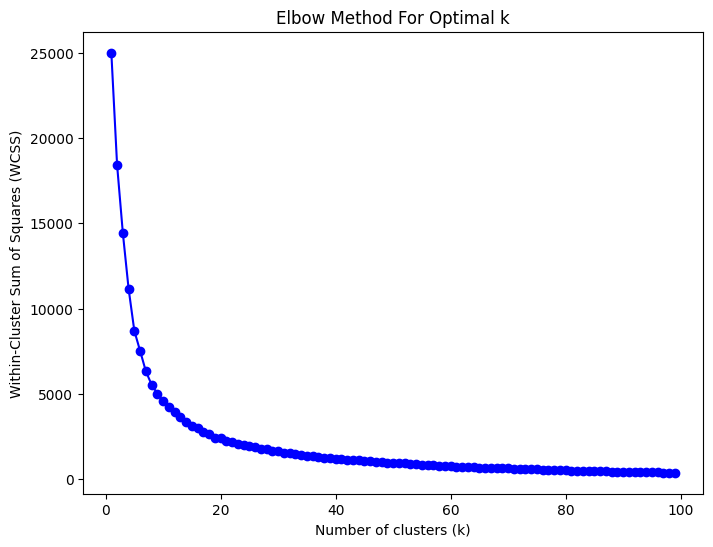

In [28]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the range of k values to try
k_values = range(1, 100)
wcss = []

# Fit K-Means for each k and calculate WCSS
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.show()

In [29]:
optimal_k = 30
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)

# Get the cluster labels
labels = kmeans.labels_
labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([ 7, 10,  7, ..., 12, 20, 20], dtype=int32)

In [30]:
# Display elements of each cluster
clusters = {i: [] for i in range(optimal_k)}
for idx, label in enumerate(labels):
    clusters[label].append(X[idx])

for cluster, elements in clusters.items():
    print(f"Cluster {cluster}:")
    for element in elements:
        print(element)

Streaming output truncated to the last 5000 lines.
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  6  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 1  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 1  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -1]
[ 2  4  0 -1 -

In [31]:
input_features = [seniority_level_mapping[seniority_input], employment_types_mapping[employment_type_input]]

for job_function in job_functions_input:
  input_features.append(job_function_to_label[job_function])

input_features = input_features + [-1] * (max_length - len(job_functions_input))
input_features_scaled = scaler.transform([input_features])

In [32]:
predicted_cluster = kmeans.predict(input_features_scaled)[0]

# Display elements of the nearest cluster
clusters = {i: [] for i in range(optimal_k)}
for idx, label in enumerate(kmeans.labels_):
    clusters[label].append(X[idx])

print(f"Input features belong to cluster {predicted_cluster}")
print(f"Elements in cluster {predicted_cluster}:")
for element in clusters[predicted_cluster]:
    print(element)

Input features belong to cluster 7
Elements in cluster 7:
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4 10  0  4]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4  0 -1 -1]
[ 3  4 

17. Below cell implement TF-IDF vectorization for job-description columns.

In [33]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Remove stopwords and lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Preprocess job descriptions
for job in data:
    job["description"] = preprocess_text(job["description"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract job descriptions
job_descriptions = [job["description"] for job in data]

# Fit TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(job_descriptions)


In [35]:
# Sample input job description
input_description = "Looking for a Human resource manager with sales experience"

# Preprocess input job description
input_description = preprocess_text(input_description)

# Transform input description to TF-IDF vector
input_vector = vectorizer.transform([input_description])


In [36]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between input vector and job descriptions
similarity_scores = cosine_similarity(input_vector, X).flatten()

# Get top N most similar job descriptions
N = 5
top_indices = similarity_scores.argsort()[-N:][::-1]

# Retrieve and print the top N most relevant job descriptions
relevant_jobs = [data[idx] for idx in top_indices]
print(f"Input description: {input_description}")
print("Top relevant job descriptions:")
for job in relevant_jobs:
    print(json.dumps(job, indent=2))


Input description: looking human resource manager sale experience
Top relevant job descriptions:
{
  "id": 246043955,
  "created": "2024-04-27",
  "last_updated": "2024-04-27",
  "time_posted": "1 month ago",
  "title": "Human Resources Manager",
  "description": "ideal candidate support full scope human resource responsibility partner organization strategic initiative maintain enhance organization human resource planning implementing evaluating human resource policy program practice responsibility recruit onboard new hire conduct performance management provide feedback manage payroll benefit employee qualification bachelor degree relevant experience 5 year experience human resource strong recruiting demonstrated ability improve talent acquisition strategy demonstrated expertise training manager employee strong organizational critical thinking communication skill attention detail good judgement",
  "seniority": 5,
  "employment_type": 4,
  "location": "Bengaluru, Karnataka, India",
  "

18. Below cell implements vectorization using word2vec loaded from gensim library.

In [37]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Remove stopwords and lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

# Preprocess job descriptions
for job in data:
    job["description_tokens"] = preprocess_text(job["description"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
from gensim.models import Word2Vec

# Prepare the training data
job_description_tokens = [job["description_tokens"] for job in data]

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=job_description_tokens, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(job_description_tokens, total_examples=len(job_description_tokens), epochs=10)


(10607389, 11298860)

19. Each description is represented as the  average of vectors of each word.

In [39]:
import numpy as np

def get_avg_word2vec(tokens, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count != 0:
        vec /= count
    return vec

vector_size = 100
for job in data:
    job["description_vector"] = get_avg_word2vec(job["description_tokens"], word2vec_model, vector_size)


In [40]:
# Sample input job description
input_description = "Looking for a software developer to create and maintain web applications."

# Preprocess input job description
input_tokens = preprocess_text(input_description)

# Convert input description to a vector
input_vector = get_avg_word2vec(input_tokens, word2vec_model, vector_size)


In [41]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between input vector and job description vectors
job_vectors = np.array([job["description_vector"] for job in data])
similarity_scores = cosine_similarity([input_vector], job_vectors).flatten()

# Get top N most similar job descriptions
N = 5
top_indices = similarity_scores.argsort()[-N:][::-1]

# Retrieve and print the top N most relevant job descriptions
relevant_jobs = [data[idx] for idx in top_indices]
print(f"Input description: {input_description}")
print("Top relevant job descriptions:")
for job in relevant_jobs:
    print(job)


Input description: Looking for a software developer to create and maintain web applications.
Top relevant job descriptions:
{'id': 243089966, 'created': '2024-04-07', 'last_updated': '2024-04-29', 'time_posted': '10 minutes ago', 'title': 'Fullstack PHP CodeIgniter developer', 'description': 'position full stack developer php codeigniter laravel company mayura consultancy service experience 1 yr 3 yr location bangalore skill html cs bootstrap javascript ajax jquery php codeigniter ci work location work homewfh mc seeking talented experienced full stack php web developer join dynamic team full stack php web developer mc responsible designing developing maintaining scalable php based web application responsibility design develop implement user interface user experience web application create maintain well structured reusable efficient code front end back end component develop interactive responsive user interface using html cs bootstrap ajax jquery javascript framework collaborate design

20. Following charts visualize the distribution of jobs across location, functional_roles, and industries.

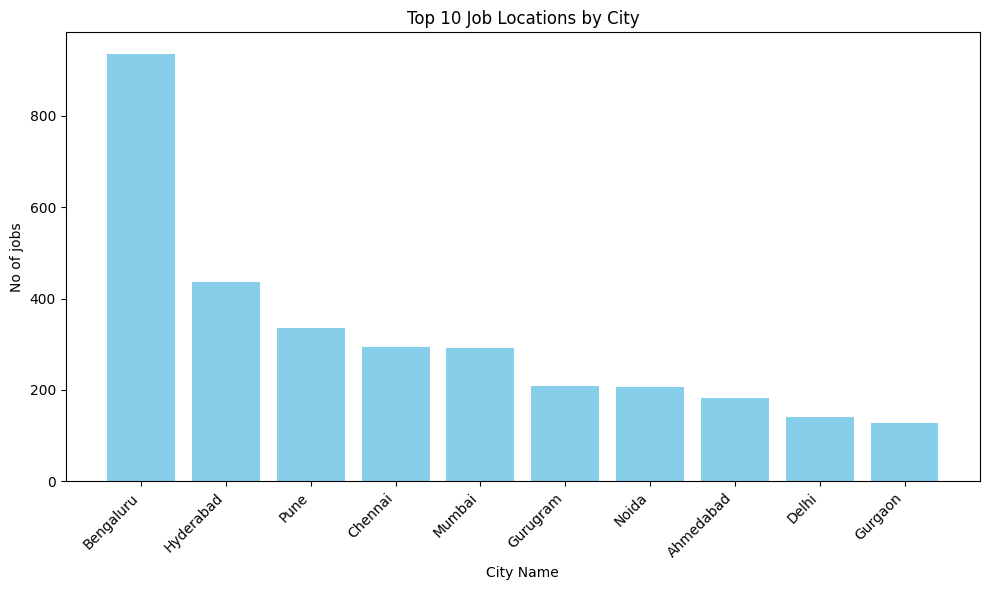

In [46]:
import matplotlib.pyplot as plt
from collections import Counter


def extract_city(location):
    if ',' in location:
        return location.split(',')[0]
    return location


city_names = [extract_city(job['location']) for job in data if extract_city(job['location']) != "India"]
city_counts = Counter(city_names)


top_cities = city_counts.most_common(10)
top_city_names = [city for city, count in top_cities]
top_frequencies = [count for city, count in top_cities]


plt.figure(figsize=(10, 6))
plt.bar(top_city_names, top_frequencies, color='skyblue')
plt.xlabel('City Name')
plt.ylabel('No of jobs')
plt.title('Top 10 Job Locations by City')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


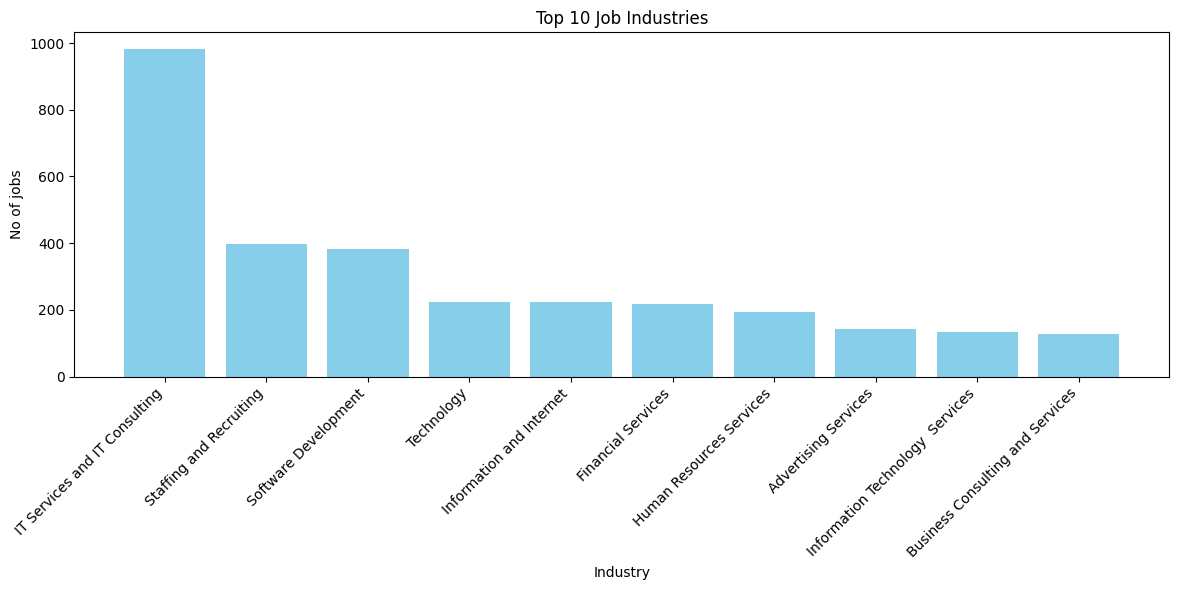

In [47]:
import matplotlib.pyplot as plt
from collections import Counter

def extract_industries(industry_list):
    industries = []
    for industry in industry_list:
        industries.extend([i.strip() for i in industry.split(',')])
    return industries

industries = []
for job in data:
    industries.extend(extract_industries(job['job_industries_collection']))

industry_counts = Counter(industries)

top_industries = industry_counts.most_common(10)
top_industry_names = [industry for industry, count in top_industries]
top_frequencies = [count for industry, count in top_industries]


plt.figure(figsize=(12, 6))
plt.bar(top_industry_names, top_frequencies, color='skyblue')
plt.xlabel('Industry')
plt.ylabel('No of jobs')
plt.title('Top 10 Job Industries')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


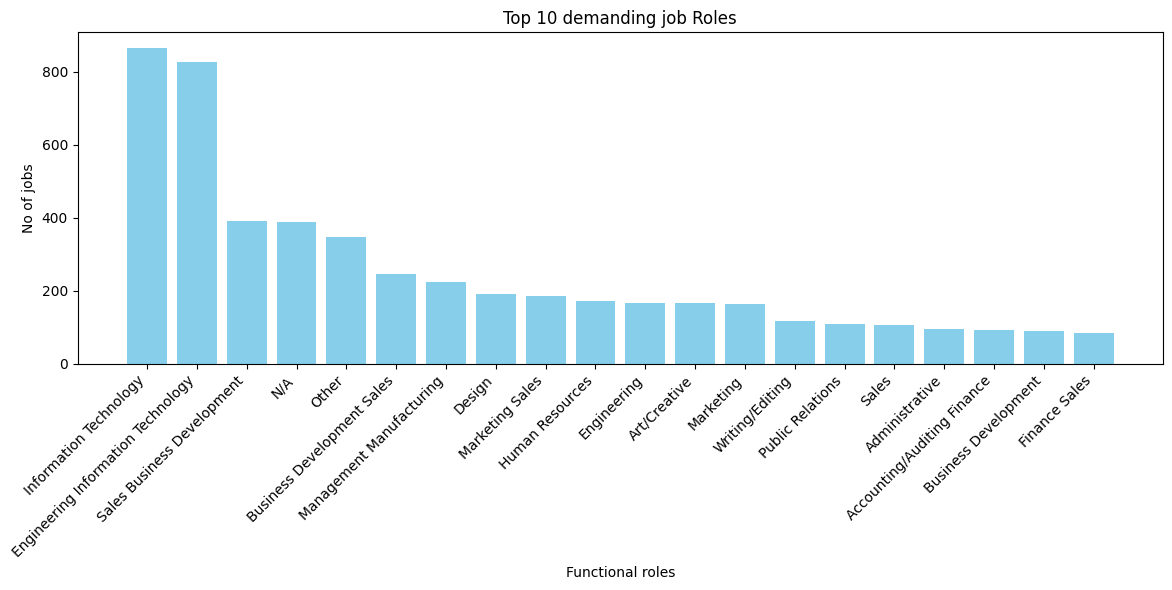

In [49]:
import matplotlib.pyplot as plt
from collections import Counter


top_industries = Counter(frequency_role).most_common(20)
top_industry_names = [industry for industry, count in top_industries]
top_frequencies = [count for industry, count in top_industries]

plt.figure(figsize=(12, 6))
plt.bar(top_industry_names, top_frequencies, color='skyblue')
plt.xlabel('Functional roles')
plt.ylabel('No of jobs')
plt.title('Top 10 demanding job Roles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
